#### Scanning the whole stack and generate projection. Padding image to avoid the artifcats

In [1]:
# import the necessary packages
import imutils
import matplotlib.pyplot as plt

import os
import numpy as np
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'
import pandas as pd
import random
import glob
from skimage import io

import argparse
import time
import cv2

#### Import the data 

In [15]:
# dataPath = 'F:\LM\digitalConfocal\data\interim\zebra_fish'  # test dataset
# dataPath = 'F:\Data\MLID\LM\zebraFish'  # whole stack images on google drive
dataPath = 'H:/My Drive/rawData/HZDR/LM/zebraFish'

In [16]:
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

In [17]:
# define the read in function for TIF

def readTIF(data_path):
    images = []
    for img in glob.glob(os.path.join(data_path, "*.tif")):
        
        im = io.imread(os.path.join(data_path, img))  
        imarray = np.array(im)
        images.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(images)

In [18]:
# read in the file and obtain the gray channel
# data formats (stack x slices x (image size))

rawData = readTIF(dataPath)  # multiple stacks, each contains two channels, each channel 20 imgs
rawGray = rawData[:,:,1,...]  # gray channel with each 20 images as one stack

print('raw data:', rawData.shape)
print('raw gray:', rawGray.shape)

# rawStack = rawGray[0,...]  # one of the stack as example
# tempStack = np.expand_dims(rawStack, axis=0)  # keep the data format similar

raw data: (19, 20, 2, 1040, 1392)
raw gray: (19, 20, 1040, 1392)


In [6]:
import napari

viewer1 = napari.view_image(rawGray[0,...])  # visualize the volume in layers
napari.run() 

#### define the parameter and data pre-processing

In [12]:
# define the parameters

# step size
# stepArray = [8, 10]
stepArray = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]
# stepArray = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
# window size
(winW, winH) = (64*2, 64*2)
# (winW, winH) = (512, 512)
# (padW, padH) = (256, 256)
(padW, padH) = (0, winH)
# (padW, padH) = (0, winH)
# saved path
# savedPath = 'F:/LM/digitalConfocal/notebooks/fMax'
# savedPath = 'F:/Data/MLID/LM/fMax_zebrafish/padMax'
savedPath = 'H:/My Drive/rawData/HZDR/LM/fMax_zebrafish/PadMax'  # google drive

In [27]:
# padding to avoid the artifacts

# target stack
# tempStackPad =np.pad(rawGray, ((0,0), (0,0), (padH,0), (padW,0)), 'constant', constant_values=27)  # use mean value of whole image
tempStackPad =np.pad(rawGray, ((0,0), (0,0), (padH,0), (padW,0)), 'constant', constant_values=27) 
print(tempStackPad.shape)

# tempStackPad =np.pad(rawGray, ((0,0), (0,0), (padH,0), (padW,0)), 'maximum')

(19, 20, 1168, 1392)


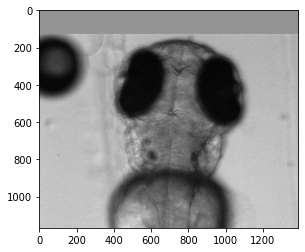

In [9]:
test = tempStackPad[0,0,...][padH:, padW:]
test1 = np.mean(rawGray[0,0,...]) 

plt.imshow(tempStackPad[0,0,...], cmap='gray')

In [10]:
del rawData #, rawGray

In [11]:
# 测试单张图片的padding和之后的裁剪

# testStack = tempStack[:1,...]
# testIMG = testStack[0,0,...]

# testPad = np.pad(testIMG, ((128,0), (128,0)), 'mean')

# unpad = testPad[128:, 128:]
# print(unpad.shape)

# plt.imshow(testPad,cmap='gray')
# plt.figure()
# plt.imshow(testIMG, cmap='gray')
# plt.figure()
# plt.imshow(unpad, cmap='gray')


# 在整个stack上面进行操作

# testStack1 = tempStack[:1,...]
# testPad1 = np.pad(testStack, ((0,0), (0,0), (128,0), (128,0)), 'mean')
# plt.imshow(testPad1[0,0,...],cmap='gray')

# unpad1 = testPad1[:,:,128:,128:]
# plt.figure()
# plt.imshow(unpad1[0,0,...], cmap='gray')

In [12]:
# # save to local 

# np.save('rawIMG.npy', tempStack)

# test = np.load('rawIMG.npy')

# viewer1 = napari.view_image(test[0,...])  # visualize the volume in layers
# napari.run() 

#### max projection in every slice in the stack

In [13]:
# create the folder to save the stacks

import os

def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)           
#     else:
#         print('path existed')

In [14]:
# multiple scans
def slidingStackSingle(image, stepArray, windowSize):
    
    focalStack = []
    
    for i in range(len(stepArray)):
        
        stepSize = stepArray[i]
        # slide a window across the image
        stdMap = np.zeros((image.shape[:2]))  # careful the image is 3 channels

        for y in range(0, image.shape[0], stepSize):
            
            for x in range(0, image.shape[1], stepSize):
                # yield the current window
                yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
                tPatch = image[y:y + windowSize[1], x:x + windowSize[0], 0]  # taking only 1 channel from 3
                tempStdPatch = np.ones((tPatch.shape)) * np.std((tPatch))
                print(tempStdPatch)
                stdMap[y:y + windowSize[1], x:x + windowSize[0]] = tempStdPatch + stdMap[y:y + windowSize[1], x:x + windowSize[0]] 
                print(stdMap.shape)
                
        focalStack.append(stdMap)
        
    # calculate the stack and conduct max projection
    fMax = np.max(np.asarray(focalStack), axis=0)
    np.save('./fMax/fMaxStack.npy', fMax)

In [15]:
# multiple scans for one image.
# input: stack num, slice num, image, step, windowsize

def slidingStack(stackNum, sliceNum, image, stepArray, windowSize, savedPath):
    
    focalStack = []
    
    for i in range(len(stepArray)):
        
        stepSize = stepArray[i]
        # slide a window across the image
        stdMap = np.zeros((image.shape[:2]))  # careful the image is 3 channels

        for y in range(0, image.shape[0], stepSize):
            for x in range(0, image.shape[1], stepSize):
                # yield the current window
                yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
                tPatch = image[y:y + windowSize[1], x:x + windowSize[0], 0]  # taking only 1 channel from 3
                tempStdPatch = np.ones((tPatch.shape)) * np.std((tPatch))
                # print(tempStdPatch)
                stdMap[y:y + windowSize[1], x:x + windowSize[0]] = tempStdPatch + stdMap[y:y + windowSize[1], x:x + windowSize[0]]
                
                # print(tempStd)
                
#         focalStack.append(stdMap)
        focalStack.append(stdMap[padH:, padW:])  # crop the feature map back 
        
    # calculate the stack and conduct max projection
    fMax = np.max(np.asarray(focalStack), axis=0)
    
    # check the saving path
    tempPath = savedPath + '/' + str(stackNum)
    mkdir(tempPath)
    
    # save the max projection in sliceNum under the path 'stackNum'
    np.save(tempPath+'/'+str(sliceNum)+'.npy', fMax)

In [16]:
#  visualize the scanning process of one image

def visualizeStack(stackNum, sliceNum, image, stepArray, windowSize, savedPath):
    
    # slide window scanning for one test
    # 可以改变window size进行多层次的扫描
    
    for (x, y, window) in slidingStack(stackNum, sliceNum, image, stepArray=stepArray, windowSize=(winW, winH), savedPath=savedPath):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        # draw the window during the process
        clone = image.copy() 
        cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)  # third param indicates the colour
        cv2.imshow("Window", clone)
        cv2.waitKey(1)
           # time.sleep(0.025)
        time.sleep(0.00025)
    cv2.destroyAllWindows() 

#### generate scan on one stack

In [17]:
# target stack

# targetStack = tempStackPad[:1,...]
targetStack = tempStackPad

# scan the images in step size
for stackNum in range(targetStack.shape[0]):
    
    for sliceNum in range(targetStack.shape[1]):
        image = np.stack((targetStack[stackNum,sliceNum,...],)*3, axis=-1) 
        for (x, y, window) in slidingStack(stackNum, sliceNum, image, stepArray=stepArray, windowSize=(winW, winH), savedPath=savedPath):
        # if the window does not meet our desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue 

#### load the max projection for next step

In [2]:
# define the read in function for max projection

def readNpy(data_path):
    fStack = []
    for img in glob.glob(os.path.join(data_path, "*.npy")):
        im = np.load(os.path.join(data_path, img))  
        imarray = np.array(im)
        fStack.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(fStack)

#### read in the results from multiple stacks

In [3]:
# # read in one stack of the images

# stackNum = 0
# fStack1 = readTIF(savedPath+'/'+str(stackNum)+'/')

In [13]:
# read in multiple stacks
fStacks = []

# for i in range(targetStack.shape[0]):
for i in range(2):
    fStackTemp = readNpy(savedPath+'/'+str(i)+'/')
    fStacks.append(fStackTemp)
    
fStacks = np.asarray(fStacks)
print(fStacks.shape)

(2, 20, 1040, 1392)


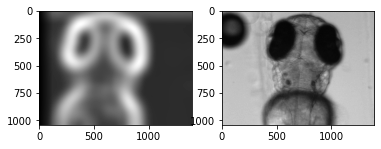

In [20]:
# 检查padding 之后裁剪的信息
import napari

# plt.imshow(fStacks[0,0,...],cmap='gray')
NUM = 2
subShow(fStacks[0,NUM,...], rawGray[0,NUM,...])

viewer1 = napari.view_image(fStacks[0,...])  # visualize the volume in layers
napari.run() 

In [22]:
# saved the processed data

stackScale = np.interp(fStacks, (fStacks.min(), fStacks.max()), (0, 255))
stackScale = stackScale.astype('uint8')
fStacks = fStacks.astype('uint8')
np.save(savedPath + '/final/fMaxPad.npy', stackScale)
# np.save('rawIMG.npy', fStacks)


#### dock the images together, see the parts in focus on orriginal images,  and check the results

In [24]:
dockIMG = []

for i in range(fStacks.shape[0]):
    tFmax = fStacks[i,...]
    tStack = np.squeeze(targetStack[:,i,:,:])
    scanScale = np.interp(tFmax, (tFmax.min(), tFmax.max()), (0, 255))  # since the original images is uint8
    sumImg = scanScale + 1 * tStack
    sumImg = np.interp(sumImg, (sumImg.min(), sumImg.max()), (0, 1))  # rescale into [0, 1]
    dockIMG.append(sumImg)
    
dockIMG = np.asarray(dockIMG)

ValueError: operands could not be broadcast together with shapes (20,1040,1392) (19,1168,1392) 

In [ ]:
viewer = napari.view_image(dockIMG)  # visualize the volume in layers
napari.run() 

#### sanity check for slices in stack

In [ ]:
# compare the generated images with the original slice
NUM = 0
tFmax = fStack1[NUM,...]; tStack = np.squeeze(targetStack[:,NUM,:,:])
plt.subplot(1,2,1)
plt.imshow(tFmax, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(tStack, cmap='gray')
plt.show()

# dock the images

scanScale = np.interp(tFmax, (tFmax.min(), tFmax.max()), (0, 255))
sumImg = scanScale + 2 * tStack
sumImg = np.interp(sumImg, (sumImg.min(), sumImg.max()), (0, 255))
plt.figure()
plt.imshow(sumImg, cmap='gray')

#### binary the feature map

In [9]:
# use the otsu to binary the image, threshold is 1979.52,
# 测试一张图片上的效果


from skimage.filters import threshold_otsu

stackMap  = np.load(savedPath+'/final/fMaxPad.npy')
# stackMap = fStacks
scaleMap = np.interp(stackMap, (stackMap.min(), stackMap.max()), (0, 1))

# scaleIMG = np.interp(rawGray, (rawGray.min(), rawGray.max()), (0, 1))

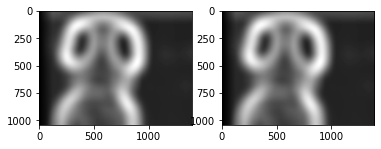

In [24]:
# plt.imshow(stackScale[0,0,...], cmap='gray')
NUM = 10
testMap = scaleMap[0,NUM,...]
# testIMG = scaleIMG[0,NUM,...]

subShow(testMap, testMap)

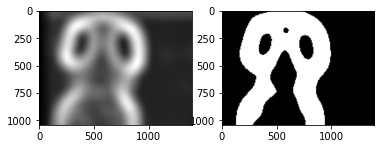

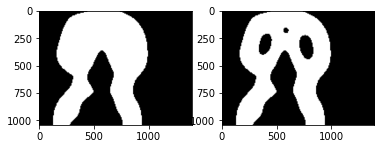

In [35]:
# Test the otsu and fill the hole

from skimage.filters import threshold_otsu

image = testMap
thresh = threshold_otsu(image)
binaryOtsu = image > thresh

subShow(testMap, binaryOtsu)

# fill the hole

from skimage.morphology import reconstruction

seed = np.copy(binaryOtsu)
seed[1:-1, 1:-1] = binaryOtsu.max()
mask = binaryOtsu

filled = reconstruction(seed, mask, method='erosion')

subShow(filled, binaryOtsu)

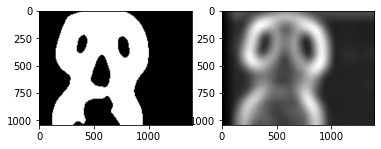

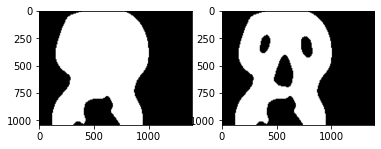

In [34]:
# test the li filter

from skimage import data,filters

thresh = filters.threshold_li(image)
binaryLi = testMap > (thresh - 0)

subShow(binaryLi, testMap)


# fill the hole

from skimage.morphology import reconstruction

seed = np.copy(binaryLi)
seed[1:-1, 1:-1] = binaryLi.max()
mask = binaryLi

filled = reconstruction(seed, mask, method='erosion')

subShow(filled, binaryLi)

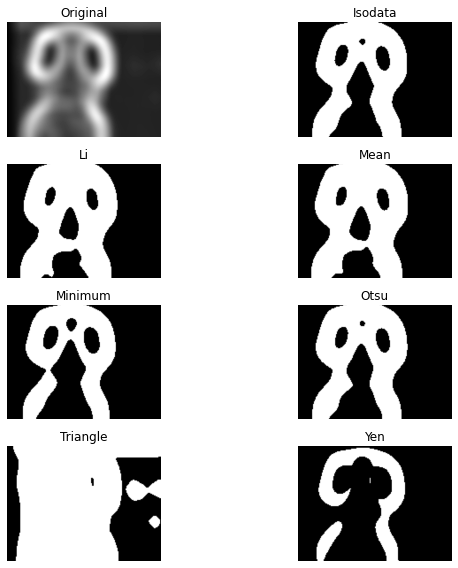

In [14]:
from skimage.filters import try_all_threshold

img = testIMG

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

In [ ]:
for i in range(fStack1.shape[0]):
    tSlice = fStack1[i,...]
    print(np.max(tSlice), np.min(tSlice))

In [ ]:
# rescale the images
# set the threshold as half of the value
scanScale = np.interp(fStack1, (fStack1.min(), fStack1.max()), (0, 1))
THRESHOLD = 0.25
biFmax = (scanScale > THRESHOLD).astype('float')

In [ ]:
# dock check the effects
biStack = np.squeeze(targetStack)
sumImg = biFmax + 2 * np.interp(biStack, (biStack.min(), biStack.max()), (0, 1))
sumImg = np.interp(sumImg, (sumImg.min(), sumImg.max()), (0, 1))
viewer = napari.view_image(sumImg)  # visualize the volume in layers
napari.run() 

In [ ]:
plt.figure()
plt.imshow(sumImg[10,...], cmap='gray')

#### write out the feature map as tif

In [ ]:
# write out the calculate mask

import numpy as np
import tifffile

with tifffile.TiffWriter('fMax.tif') as tif:
  for i in range(fStack1.shape[0]):
    filename = f"image_{i}"
    tif.save(fStack1[i,...], photometric='minisblack', description=filename, metadata=None)

In [ ]:
test = io.imread('./fMax.tif')  
viewer = napari.view_image(test)  # visualize the volume in layers
napari.run() 